## Load the required packages

In [20]:
import alphaspace2 as al
import mdtraj
import numpy as np
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import fcluster, linkage
from alphaspace2.functions import _binCluster, _group
from alphaspace2.Cluster import _DPocket

import features  ## python module with pseudomolecular features
import glob
from collections import defaultdict 
import matplotlib.pyplot as plt

## Name the protein and ligand

In [21]:
protease_list = ['PPLCPIPE', 'PPLCPSPE0', 'PPLCPSPE1',  'PPLCPSPE3', 'PPLCPSPE4', 'RRLCPVPE - good', 'RRVCPVPE0', 'RRVCPVPE1']

## Calculating pockets for proteases, pka, and estrogen receptor

In [22]:
lig= mdtraj.load('./data/rec.pdb')
protease_data_ss = {}
protease_data_prot = {}
for protease in protease_list:
    prot = mdtraj.load('./data/'+protease+'.pdb')
    protease_data_prot[protease] = prot
    ss_prot = al.Snapshot()
    ss_prot.run(prot, lig)
    protease_data_ss[protease] = ss_prot

## Calculating ensemble pockets for proteases, pka, and estrogen receptor systems
#### Also extracting contact pockets and calculating USR and occluded ASA properties 

In [23]:
protease_trajectory = al.Trajectory(snapshots=[protease_data_ss[protease] for protease in protease_data_ss.keys()])
protease_trajectory.gen_dpockets(clust_distance=4.7)
dps = sorted([dp for dp in protease_trajectory.dpockets],key=lambda i:sum(i.scores))

protease_contact_pockets = defaultdict(dict)
for dpx,dp in enumerate(dps):
    pockets = list(dp.pockets)
    for px,pdb_id in enumerate(protease_data_ss.keys()):
        if pockets[px].isContact:
            protease_contact_pockets[pdb_id][dpx] = np.array([b.xyz for b in pockets[px].betas])
            
protease_props_dict = {}
for pdb_id in protease_contact_pockets:
    contact_betas = []
    prot = protease_data_prot[pdb_id]
    for dpx in protease_contact_pockets[pdb_id]:
        contact_betas.extend(protease_contact_pockets[pdb_id][dpx])
        
    contact_betas = np.array(contact_betas)
    beta_temp_dict = {}
    beta_temp_dict['occluded_asa'] = features._get_pharmacophore_fingerprint(prot,contact_betas)
    beta_temp_dict['usr'] = features._Get_USR_alpha_beta(contact_betas)
    protease_props_dict[pdb_id] = beta_temp_dict 

## Define an array of USR features for the heatmap comparison

In [24]:
usr_arrays = []
for pdb_id in protease_contact_pockets:
    usr_arrays.append([s for _,s in protease_props_dict[pdb_id]['usr'].items()])

### Plotting the heatmap of USR features

In [26]:
usr_heatmap = np.ones((30,30))
for ix in range(len(usr_arrays)-1):
    usr_b1 = usr_arrays[ix]
    for jx in range(ix+1,len(usr_arrays)):
        usr_b2 = usr_arrays[jx]
        sim = 1 - features._soergel(usr_b1,usr_b2)
        usr_heatmap[ix,jx] = sim
        usr_heatmap[jx,ix] = sim 
a = 1

### Plotting heatmap similarities using the USR features
#### We define vmin as 0.7 (from observation of large numbers of structures,
#### We observe that a similarity of <0.7 may be defined as dissimilar while anything larger than 0.7 may be similar)

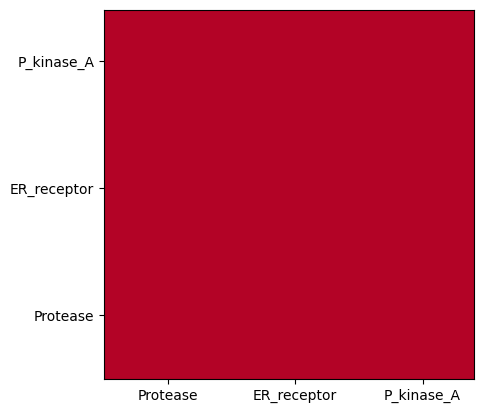

In [16]:
plt.imshow(usr_heatmap, cmap='coolwarm', vmin = 0.7, vmax = 1.0)
plt.xticks([5,15,25],['Protease','ER_receptor','P_kinase_A'],rotation=0)
plt.yticks([5,15,25],['Protease','ER_receptor','P_kinase_A'])
plt.axis([0,29,0,29])
plt.show()